# Compute the SNR for multipoles of the bispectrum

In [1]:
import numpy as np
from sympy import var
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from scipy import integrate
from numba import jit
import scipy
from classy import Class
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon
from scipy.interpolate import interp1d
from scipy.integrate import odeint

import cosmo_wap as cw
import cosmo_wap.bk as bk #import terms for the bispectrum

# Import the plot style settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('font', size='22')

In [4]:
def get_cosmo(h,Omega_b,Omega_cdm,Omega_m,A_s,n_s,sigma8=0):
    
    #Create a params dictionary
    params = {'output':'mPk,mTk',
                 'non linear':'halofit',
                 'Omega_b':Omega_b,
                 'Omega_cdm':Omega_cdm,#Omega_m-Omega_b,#
                 'h':h,
                 'n_s':n_s,
                 'A_s':A_s,#'n_s':n_s,'sigma8':0.828,#
                 'P_k_max_1/Mpc':k_max,
                 'z_max_pk':10. #Default value is 10
    }
    if sigma8 !=0:
        params = {'output':'mPk,mTk',
                 'non linear':'halofit',
                 'Omega_b':0.02242/h**2,
                 'Omega_cdm':Omega_m-Omega_b,#Omega_cdm,#
                 'h':h,
                 'n_s':n_s,
                 'sigma8':0.828,#'A_s':A_s,#'n_s':n_s,
                 'P_k_max_1/Mpc':k_max,
                 'z_max_pk':10. #Default value is 10
                 }
        

    #Initialize the cosmology and compute everything
    cosmo = Class()
    cosmo.set(params)
    cosmo.compute()
    
    return cosmo
#Need to specify the max wavenumber
k_max = 100 #UNITS: 1/Mpc # is also set to 10 later
#Start by specifying the cosmology  - planck best fit
h = 0.6766
Omega_b = 0.02242/h**2
Omega_cdm = 0.11933/h**2
Omega_m = Omega_cdm+Omega_b
A_s = 2.105e-9 
n_s = 0.9665

cosmo = get_cosmo(h,Omega_b,Omega_cdm,Omega_m,A_s,n_s)

#scoccimarro and noorikuhani cosmology
Omega_m = 0.32
sigma8 = 0.828
n_s = 0.968

cosmo_noor = get_cosmo(h,Omega_b,Omega_cdm,Omega_m,A_s,n_s,sigma8=sigma8)

## Import expression for each contributions

In [5]:
survey_params = cw.SurveyParams(cosmo)

cosmo_funcs = cw.ClassWAP(cosmo,[survey_params.Euclid],compute_bias=True)

Computing bias params...


In [6]:
print(cosmo_funcs.D_intp(1.5))
print(cosmo_funcs.D_intp(1.5)**4)

0.49741855672861246
0.06121923977806001


In [7]:
survey_params = cw.SurveyParams(cosmo)
cosmo_funcs = cw.ClassWAP(cosmo,[survey_params.Euclid],compute_bias=True)
#cosmo_funcs_ST = cw.ClassWAP(cosmo,[survey_params.Euclid],compute_bias=True,HMF='ST')
#cosmo_funcs2 = cw.ClassWAP(cosmo,[survey_params.Euclid],compute_bias=False)

Computing bias params...


In [5]:
survey_params.CV_limit.b_1 = lambda zz: np.sqrt(1+zz)#0.9 + 0.4*zz#0.9 + 0.4*xx   # 1.45 + 0.68*(zz-1) # np.sqrt(1+zz) 
survey_params.CV_limit.z_range = [0.1,2.2]

In [26]:
survey_params.CV_limit.z_range

[0.1, 2.2]

In [66]:
cosmo_funcs = cw.ClassWAP(cosmo,[survey_params.CV_limit],compute_bias=False)

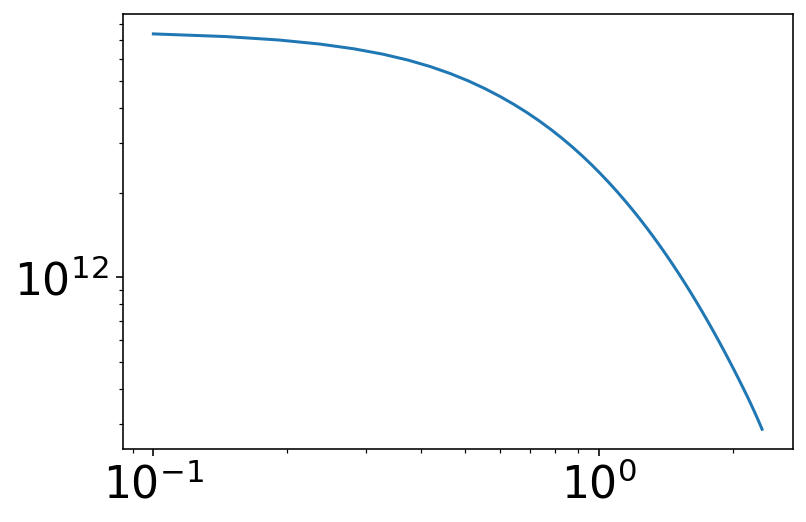

In [71]:
plt.plot(z_plot,cosmo_funcs.survey.M0_func(z_plot))
plt.yscale('log')
plt.xscale('log')

In [12]:
from cosmo_wap import peak_background_bias as pb_bias

survey_bias = pb_bias.PBBias(cosmo_funcs, survey_params.CV_limit)


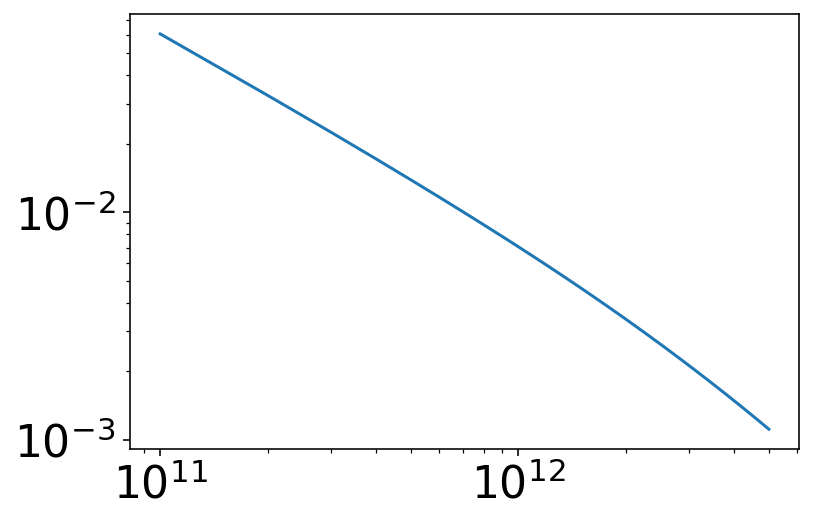

In [18]:
xx = np.linspace(5e+12,1e+11)
plt.loglog(xx,[survey_bias.general_galaxy_bias(survey_bias.eulbias.b1,2.3,xxx,1) for xxx in xx])

In [9]:

z_plot = np.linspace(0.1,2.2)
plt.plot(z_plot,survey_bias.b_1(z_plot))
#plt.plot(z_plot,cosmo_funcs.survey.b_2(z_plot))
#plt.plot(z_plot,cosmo_funcs.survey.loc.b_11(z_plot))
#plt.plot(z_plot,cosmo_funcs.survey.loc.b_01(z_plot))

NameError: name 'survey_bias' is not defined

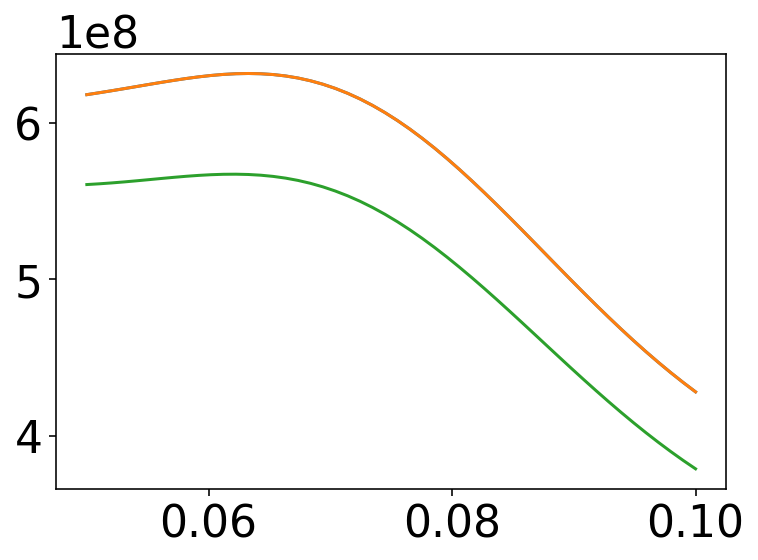

In [6]:
zz=np.linspace(1,1.5,40)[...,np.newaxis] # redshift
k1=np.linspace(0.05,0.1)
k2=k1
k3=0.1*k1


#print(cw.integrate.ylm(bk.Bk_0,0,0,cosmo_funcs,k1,k2,k3,zz=zz,sigma=4).shape)
#plt.plot(k1,(150)*np.sqrt(bk.COV.N00(cosmo_funcs,k1,k2,k3,zz=zz)))
#plt.plot(k1,bk.Bk0.l0(cosmo_funcs,k1,k2,k3,zz=zz))

plt.plot(k1,bk.Bk0.ylm(0,0,cosmo_funcs,k1,k2,k3,zz=zz,sigma=4).real[0])
plt.plot(k1,cw.integrate.ylm(bk.Bk_0,0,0,cosmo_funcs,k1,k2,k3,zz=zz,sigma=4).real[20])

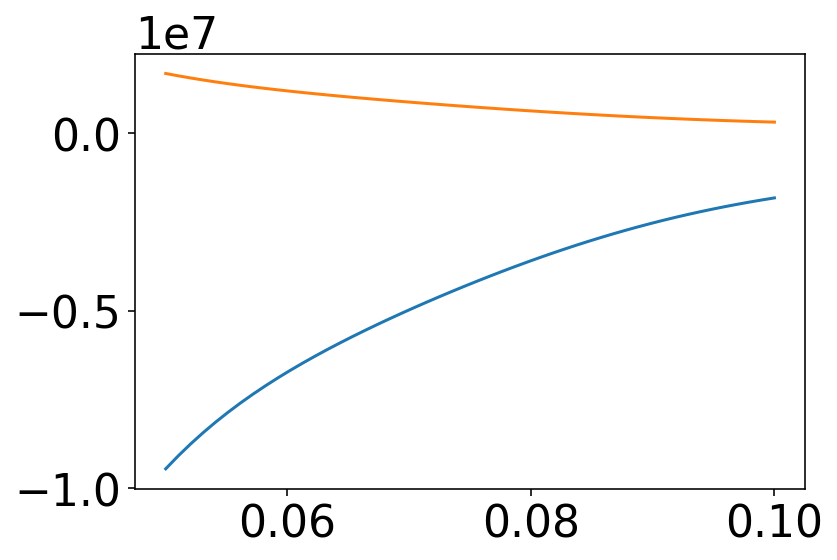

In [6]:
plt.plot(k1,bk.Loc.l0(cosmo_funcs,k1,k2,k3,zz=0))
plt.plot(k1,bk.Loc.l2(cosmo_funcs,k1,k2,k3,zz=0))

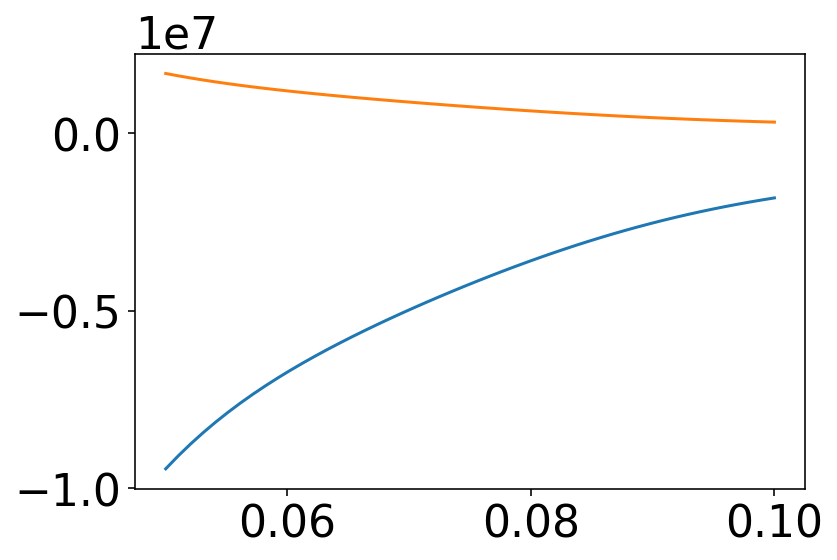

In [54]:
plt.plot(k1,bk.Loc.l0(cosmo_funcs,k1,k2,k3,zz=0))
plt.plot(k1,bk.Loc.l2(cosmo_funcs,k1,k2,k3,zz=0))

In [8]:
k1=k2=0.08;k3=0.05

In [9]:
V123 = 8*np.pi**2*k1*k2*k3*(2)**3 #from thin bin limit -Ntri
V123 = np.where(np.isclose(k1,k3 + k2),V123/2,V123) #beta

cov = bk.COV(cosmo_funcs,k1,k2,k3,zz=1)
#theory = np.sqrt(bk.COV.N00(cosmo_funcs,k1,k2,k3,zz=0)/V123 *(4*np.pi))
theory  =  (cov.N00()/V123)*(4*np.pi)**2  *2 
theory1  =  (cov.N20_00()/V123)*(4*np.pi)**2  *2 
theory2  =  (cov.N20()/V123)*(4*np.pi)**2  *2 

NameError: name 'cosmo_functions' is not defined

In [33]:
cov_mat = np.array([[theory,theory1*1],[theory1*1,theory2]])

In [34]:
print(cov_mat)
print(np.linalg.inv(cov_mat))

[[1.95075876e+16 5.90338753e+15]
 [5.90338753e+15 2.37714659e+16]]
[[ 5.54276258e-17 -1.37648539e-17]
 [-1.37648539e-17  4.54855948e-17]]


In [32]:
print(cov_mat)
print(np.linalg.inv(cov_mat))

[[1.95075876e+16 0.00000000e+00]
 [0.00000000e+00 2.37714659e+16]]
[[5.12621047e-17 0.00000000e+00]
 [0.00000000e+00 4.20672416e-17]]


In [25]:
np.linalg.inv(cov_mat)

array([[ 5.54276258e-17, -1.37648539e-17],
       [-1.37648539e-17,  4.54855948e-17]])

In [7]:
#snr_WA1, z_mid = cw.forecast.get_SNR(bk.WA_1,1,0,cosmo_funcs,r=0,s=0,sigma=3)
snr_Eq, z_mid = cw.forecast.get_SNR(bk.Eq,0,0,cosmo_funcs,r=0,s=0)
snr_Orth, z_mid = cw.forecast.get_SNR(bk.Orth,0,0,cosmo_funcs,r=0,s=0)
snr_Loc, z_mid = cw.forecast.get_SNR(bk.Loc,0,0,cosmo_funcs,r=0,s=0)
#snr_Orth, z_mid = cw.forecast.get_SNR(bk.Orth,0,0,cosmo_funcs,r=0,s=0)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
kmax_func = lambda zz: 0.1 *cosmo_funcs.h*(1+zz)**(2/(2+cosmo_funcs.cosmo.get_current_derived_parameters(['n_s'])['n_s']))
#kmax_func = lambda zz: 0.1 + 0*zz

In [12]:
bk_fore = cw.forecast.BkForecast([0.9,1.8],cosmo_funcs,k_max=0.1,s_k=1,verbose=False)

In [92]:
pk_fore = cw.forecast.PkForecast([0.9,1.8],cosmo_funcs,k_max=0.1,s_k=1,verbose=False)

In [93]:
test = pk_fore.get_cov_mat([0,2])
print(test[:,:,0])
print(pk_fore.invert_matrix(test)[:,:,0])

AttributeError: 'PkForecast' object has no attribute 'get_cov_mat'

In [13]:
test = bk_fore.get_cov_mat([0,2])
print(test[:,:,0])
print(bk_fore.invert_matrix(test)[:,:,0])

[[1.30850765e+22 2.08640660e+21]
 [2.08640660e+21 1.45840373e+22]]
[[ 7.82069151e-23 -1.11883576e-23]
 [-1.11883576e-23  7.01687362e-23]]


In [26]:
bk_fore.SNR(bk.Eq,[0,2])

0.00017339154295387897

In [58]:
l=[2]
m=0
SNR,z_mid = cw.forecast.get_SNR(bk.WA2,l,m,cosmo_funcs,r=1/3,s=1/3,verbose=True,kmax_func=kmax_func,sigma=None)

  0%|          | 0/9 [00:00<?, ?it/s]

(0.37489873+0j)


/opt/jupyterhub/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


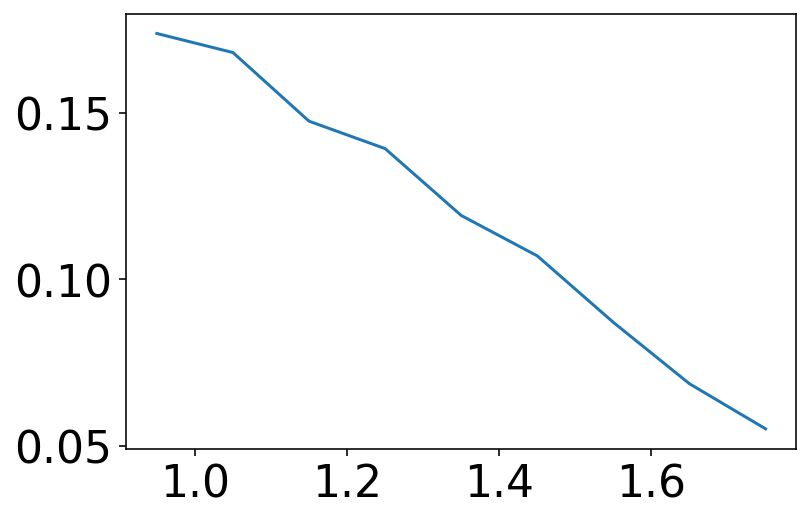

In [59]:
print(np.sqrt(np.sum(SNR)))
plt.plot(z_mid,np.sqrt(SNR))

In [46]:
print(dir(bk.PNG_))

['Eq_', 'Loc_', 'Orth_', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'np']


(925,)


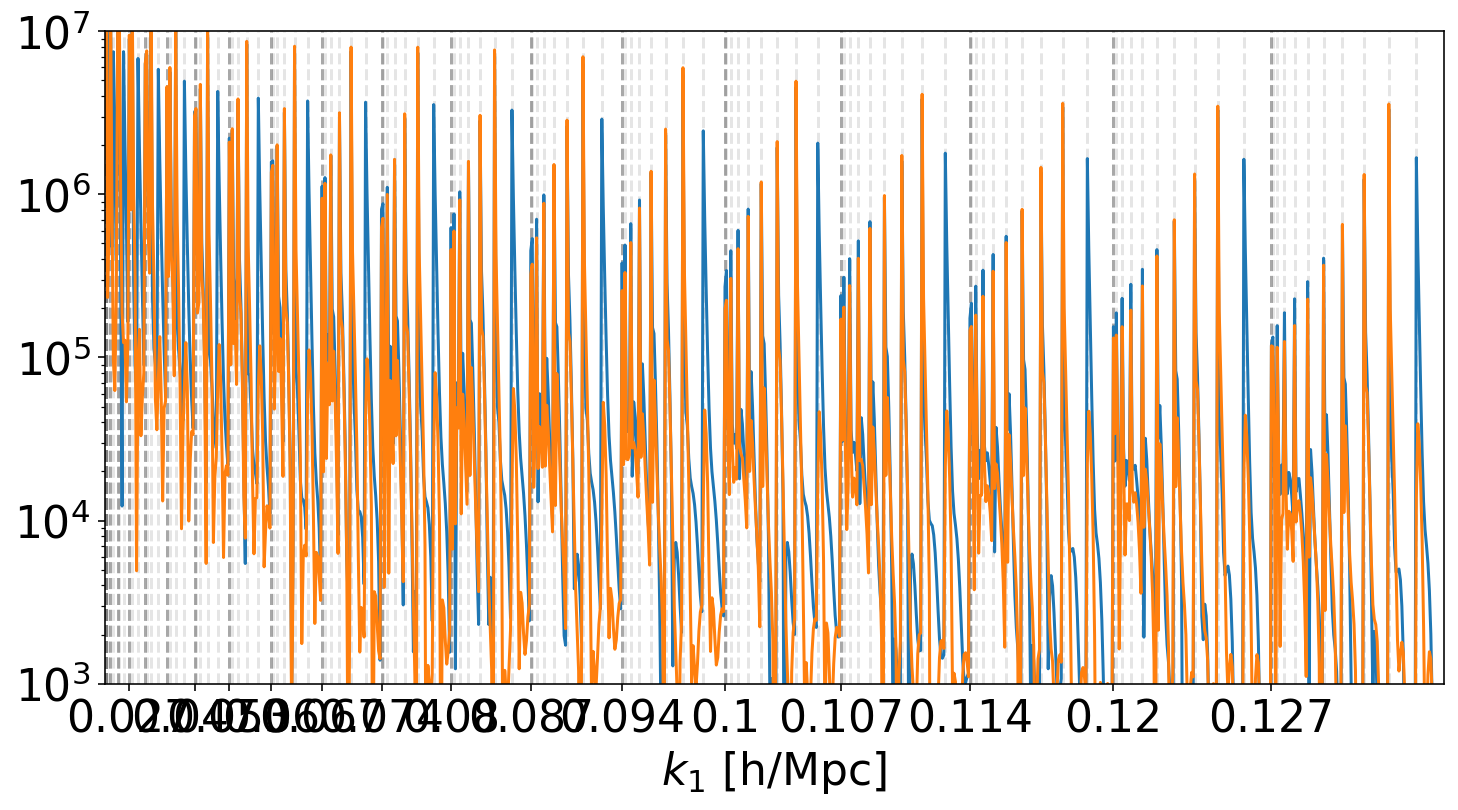

In [65]:
bk_fore = cw.forecast.BkForecast([0.9,1.1],cosmo_funcs,k_max=0.14,s_k=3,verbose=False)
k1,k2,k3,theta,s123,mesh_index,tri_bool = plot_all(bk_fore.k_bin,ymin=1e+3,ymax=1e+7,ax=None)

plt.yscale('log')
V123 = bk_fore.V123
s123 = bk_fore.s123
cosmo_funcs,k1,k2,k3,theta,zz = bk_fore.args
print(k1.shape)

cov = bk.COV(cosmo_funcs,k1,k2,k3,zz=1)
#theory = np.sqrt(bk.COV.N00(cosmo_funcs,k1,k2,k3,zz=0)/V123 *(4*np.pi))
theory  =  (s123*cov.N00()/V123)*(4*np.pi)**2  *2 
theory3 = (s123*cov.NL00()/V123 )*(4*np.pi)**2 *(2) 
theory2  =  (s123*cov.N20()/V123)*(4*np.pi)**2  *2 
#plt.plot(np.arange(len(k1)),np.sqrt(theory))
#plt.plot(np.arange(len(k1)),np.sqrt(theory2))


#plt.plot(np.arange(len(k1)),np.abs(bk.GR2.l0(cosmo_funcs,k1,k2,k3,theta,zz=1)/np.sqrt(theory)))
#plt.plot(np.arange(len(k1)),np.abs(bk.GR2.l2(cosmo_funcs,k1,k2,k3,theta,zz=1)/np.sqrt(theory2)))
l0 = bk.Loc.l0(cosmo_funcs,k1,k2,k3,theta,zz=1)
l2 = bk.WA2.l0(cosmo_funcs,k1,k2,k3,theta,zz=1)


#plt.plot(np.arange(len(k1)),np.abs(cw.integrate.ylm(bk.PNG_.Eq_,2,0,cosmo_funcs,k1,k2,k3,theta,zz=1,sigma=None,n=30)))
#plt.plot(np.arange(len(k1)),np.abs(bk.Orth.ylm(2,0,cosmo_funcs,k1,k2,k3,theta,zz=1,sigma=4)/l2))

#plt.plot(np.arange(len(k1)),np.abs(l0))
plt.plot(np.arange(len(k1)),np.abs(bk.WA2.l0(cosmo_funcs,k1,k2,k3,theta,zz=1)))
plt.plot(np.arange(len(k1)),np.abs(bk.WA2.l0(cosmo_funcs,k1,k2,k3,theta,r=1/3,s=1/3,zz=1)))
#plt.plot(np.arange(len(k1)),np.abs(bk.Loc.ylm(0,0,cosmo_funcs,k1,k2,k3,theta,zz=1,sigma=None)))
#plt.plot(np.arange(len(k1)),np.abs(bk.Orth.ylm(2,0,cosmo_funcs,k1,k2,k3,theta,zz=1,sigma=4)))

$$\Delta\theta = F^{-1} \sum_{i,j} (\nabla_{\theta}\hat{\Psi}_i^{fid}) (\text{Cov}^{-1}(\theta))_{ij} (\Psi^d_j -\hat{\Psi}_j^{fid})^*$$

In [89]:
def best_fit_bias(func,func2,l,m,cosmo_funcs,r=0,s=0,verbose=True,kmax_func=kmax_func):
    fisher = cw.forecast.fisherij(func,func,l,m,cosmo_funcs,r=r,s=s,verbose=verbose,kmax_func=kmax_func)
    
    #fisher2 = cw.forecast.fisherij(func2,func2,l,m,cosmo_funcs,r=r,s=s,verbose=verbose,kmax_func=kmax_func)
    
    fishbias = cw.forecast.fisherij(func,func2,l,m,cosmo_funcs,r=r,s=s,verbose=verbose,kmax_func=kmax_func)
    
    return fishbias/fisher,fisher

In [90]:
l=0;m=0
bias,F = best_fit_bias(bk.Loc,bk.GR2,l,m,cosmo_funcs,kmax_func=kmax_func)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [91]:
ll = 1/np.sqrt(F)
#print(ll)
print(bias/(ll))

-0.9528824917629208


In [41]:
F_ = {}
F_GR2 = {}
#F_WA2 = {}
#F_RR2 = {}
#F_WAGR = {}
#F_RRGR = {}
#F_WARR = {}

F_WS = {}
F_WSGR = {}
F_Full = {}

In [62]:
l=[0,2];m=0;
verbose=True
for i,shape in enumerate(['Loc','Eq','Orth']):#
    F_GR2[shape], F_[shape] = best_fit_bias(getattr(bk, shape),bk.GR2,l,m,cosmo_funcs,verbose=verbose)
    
    #F_WS[shape], F_[shape] = best_fit_bias(getattr(bk, shape),bk.WS,l,m,cosmo_funcs,verbose=verbose)
    #F_WSGR[shape], F_[shape] = best_fit_bias(getattr(bk, shape),bk.WSGR,l,m,cosmo_funcs,verbose=verbose)
    F_Full[shape], F_[shape] = best_fit_bias(getattr(bk, shape),bk.Full,l,m,cosmo_funcs,verbose=verbose)
    
    #F_WA2[shape], F_[shape] = best_fit_bias(getattr(bk, shape),bk.WA2,l,m,cosmo_funcs,verbose=False)
    #F_RR2[shape], F_[shape] = best_fit_bias(getattr(bk, shape),bk.RR2,l,m,cosmo_funcs,verbose=False)
    #F_WAGR[shape], F_[shape] = best_fit_bias(getattr(bk, shape),bk.WAGR,l,m,cosmo_funcs,verbose=False)
    #F_RRGR[shape], F_[shape] = best_fit_bias(getattr(bk, shape),bk.RRGR,l,m,cosmo_funcs,verbose=False)
    #F_WARR[shape], F_[shape] = best_fit_bias(getattr(bk, shape),bk.WARR,l,m,cosmo_funcs,verbose=False)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [63]:
print(F_GR2['Eq'])
print(F_Full['Eq'])

8.759377
6.1170526


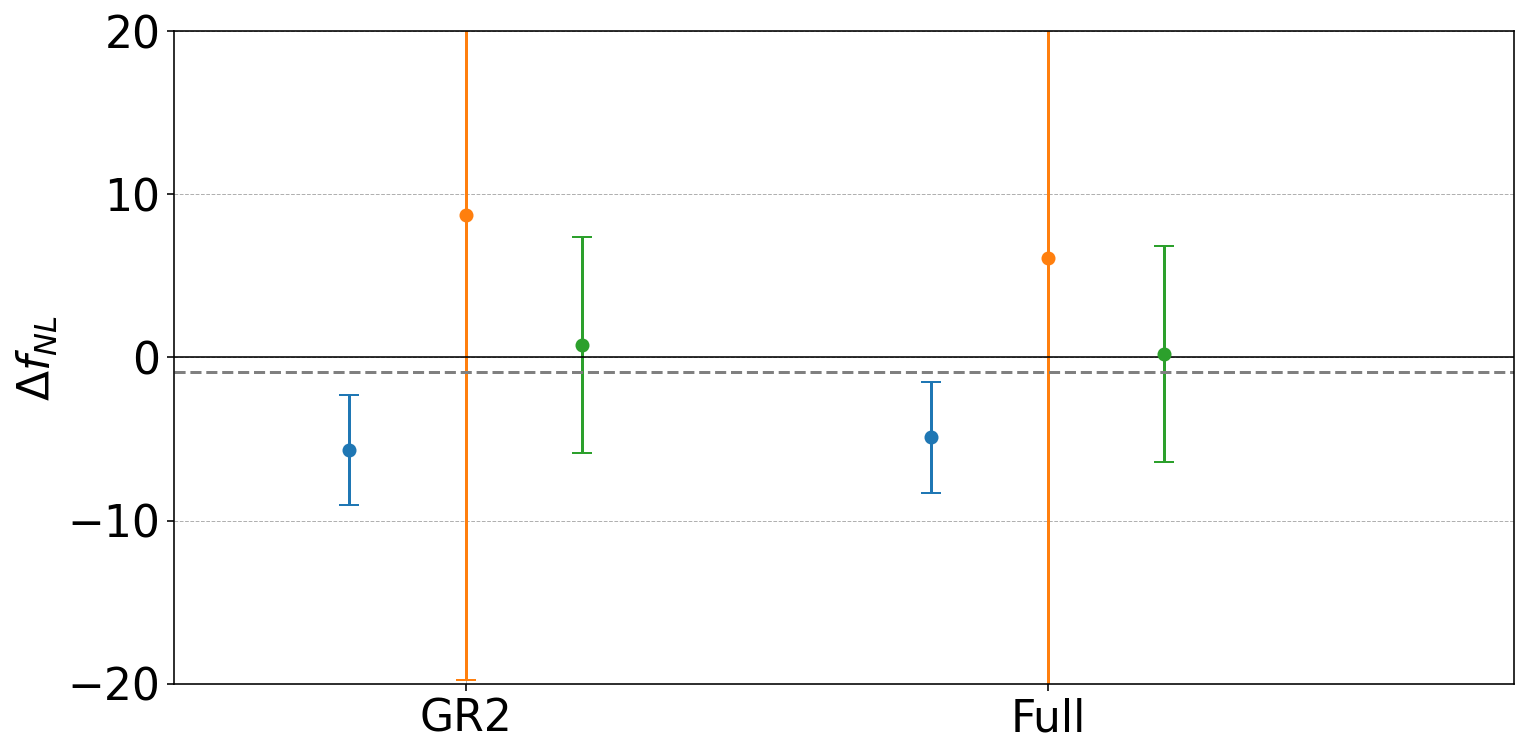

In [83]:
# Parameters
terms = [F_GR2,F_Full]#F_WS,F_WSGRF_WA2[shape],F_RR2[shape],F_WAGR[shape],F_RRGR[shape]

x = np.arange(len(terms))  # Label positions
width = 0.2  # Bar width

plt.figure(figsize=(12,6))
for i, shape in enumerate(['Loc', 'Eq', 'Orth']):#
    biases = [term[shape] for term in terms]
    
    plt.errorbar(x + i * width, biases, yerr=1/np.sqrt(F_[shape]), fmt='o', capsize=5)

# Customization
plt.axhline(-0.9,linestyle='--',color='grey')

x_range = np.linspace(-0.3,2)

#plt.fill_between(x_range, np.ones_like(x_range)*-6, np.ones_like(x_range)* 4.2, color='gray', alpha=0.5)

custom_xticks = x + width  # Shift tick labels slightly for better positioning
custom_labels = ['GR2', 'Full']  # Replace with appropriate labels

# Apply custom x-tick labels
plt.xticks(custom_xticks, custom_labels)

plt.axhline(0, color='black', linewidth=0.8) 
plt.ylabel('$\Delta f_{NL}$')
plt.grid(ls='--',lw=0.5)
#ax.legend()
plt.ylim(-20,20)
plt.xlim(x_range[0],x_range[-1])
plt.show()

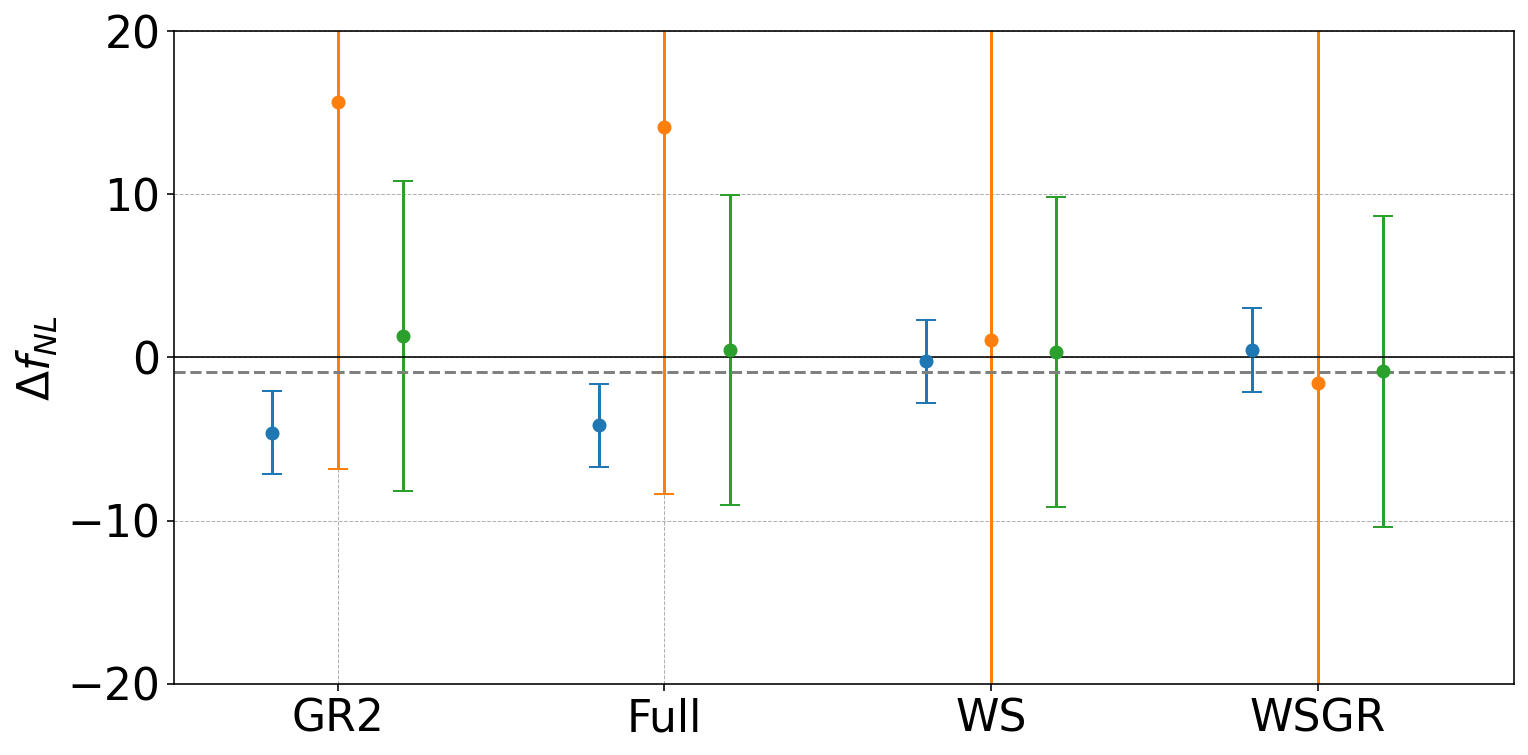

In [43]:
# Parameters
terms = [F_GR2,F_Full,F_WS,F_WSGR]#F_WA2[shape],F_RR2[shape],F_WAGR[shape],F_RRGR[shape]

x = np.arange(len(terms))  # Label positions
width = 0.2  # Bar width

plt.figure(figsize=(12,6))
for i, shape in enumerate(['Loc', 'Eq', 'Orth']):#
    biases = [term[shape] for term in terms]
    
    plt.errorbar(x + i * width, biases, yerr=1/np.sqrt(F_[shape]), fmt='o', capsize=5)

# Customization
plt.axhline(-0.9,linestyle='--',color='grey')

x_range = np.linspace(-0.3,3.8)

#plt.fill_between(x_range, np.ones_like(x_range)*-6, np.ones_like(x_range)* 4.2, color='gray', alpha=0.5)

custom_xticks = x + width  # Shift tick labels slightly for better positioning
custom_labels = ['GR2', 'Full', 'WS', 'WSGR']  # Replace with appropriate labels

# Apply custom x-tick labels
plt.xticks(custom_xticks, custom_labels)

plt.axhline(0, color='black', linewidth=0.8)  # Baseline for negatives
plt.ylabel('$\Delta f_{NL}$')
plt.grid(ls='--',lw=0.5)
#ax.legend()
plt.ylim(-20,20)
plt.xlim(x_range[0],x_range[-1])
plt.show()

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


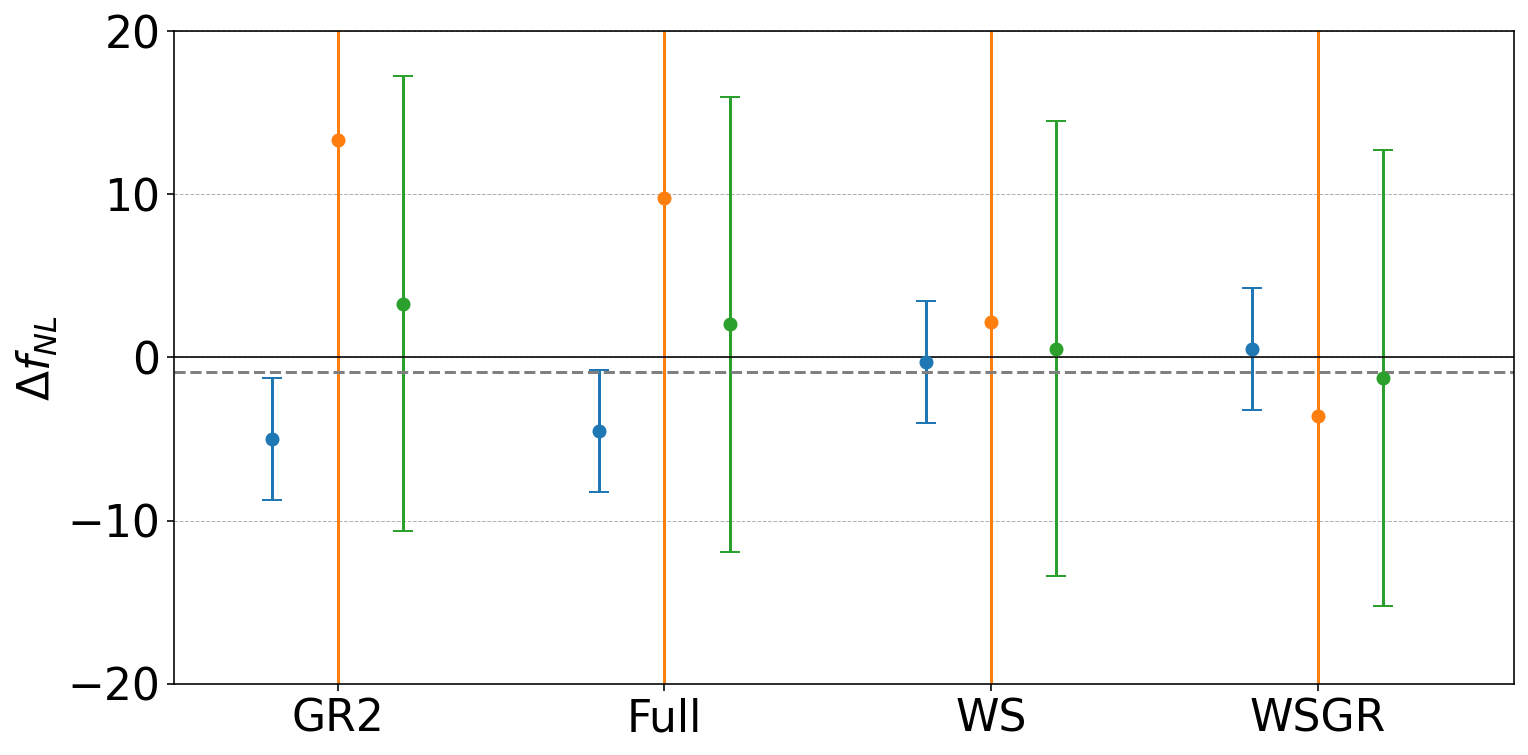

In [101]:

# Parameters
terms = [F_GR2,F_Full,F_WS,F_WSGR]#F_WA2[shape],F_RR2[shape],F_WAGR[shape],F_RRGR[shape]

x = np.arange(len(terms))  # Label positions
width = 0.2  # Bar width

plt.figure(figsize=(12,6))
for i, shape in enumerate(['Loc', 'Eq', 'Orth']):#
    biases = [term[shape] for term in terms]
    
    plt.errorbar(x + i * width, biases, yerr=1/np.sqrt(F_[shape]), fmt='o', capsize=5)

# Customization
plt.axhline(-0.9,linestyle='--',color='grey')

x_range = np.linspace(-0.3,3.8)

#plt.fill_between(x_range, np.ones_like(x_range)*-6, np.ones_like(x_range)* 4.2, color='gray', alpha=0.5)

#custom_xticks = x + width  # Shift tick labels slightly for better positioning
#custom_labels = ['GR2', 'Full', 'WS', 'WSGR']  # Replace with appropriate labels

# Apply custom x-tick labels
plt.xticks(custom_xticks, custom_labels)

plt.axhline(0, color='black', linewidth=0.8)  # Baseline for negatives
plt.ylabel('$\Delta f_{NL}$')
plt.grid(ls='--',lw=0.5)
#ax.legend()
plt.ylim(-20,20)
plt.xlim(x_range[0],x_range[-1])
plt.show()

In [11]:
print(WAbias/snr_Eq)

[12.462572+0.j 15.411713+0.j 11.075606+0.j 13.000499+0.j 14.369656+0.j
 15.093126+0.j 15.239155+0.j 12.394023+0.j 12.510965+0.j]


0.26713413
0.023023997
0.07158292


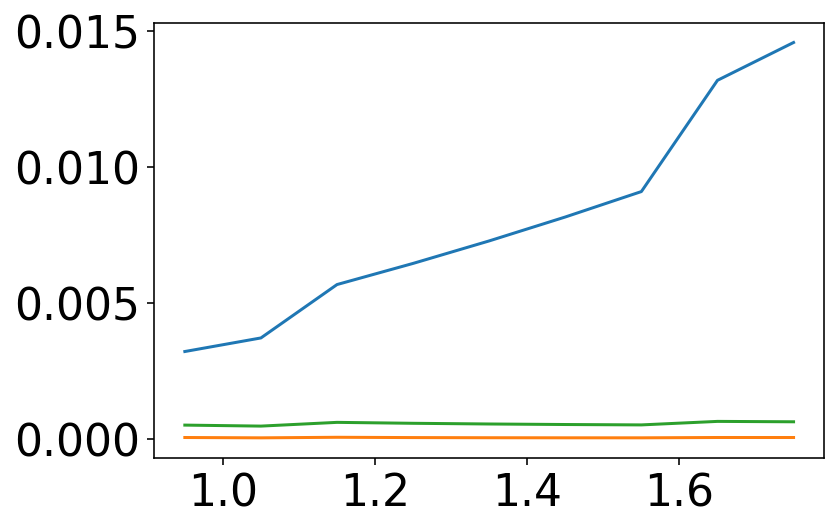

In [36]:
print(np.sqrt(np.sum(snr_Loc.real)))
print(np.sqrt(np.sum(snr_Eq.real)))
print(np.sqrt(np.sum(snr_Orth.real)))
plt.plot(z_mid,snr_Loc.real)
plt.plot(z_mid,snr_Eq.real)
plt.plot(z_mid,snr_Orth.real)

/opt/jupyterhub/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/jupyterhub/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


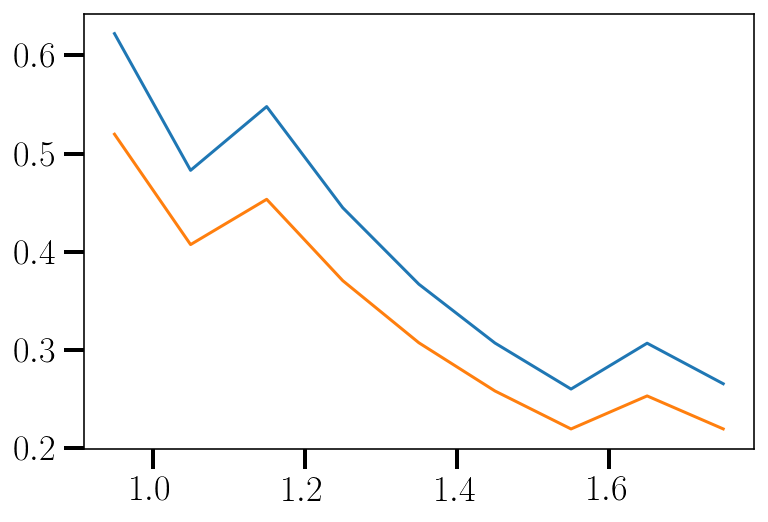

In [41]:
plt.plot(z_mid,snr_WA1)
plt.plot(z_mid,snr_WA11_)

In [57]:
survey = 'SKAO2'

print('WA=',np.sqrt(np.sum(snr_WA1[survey])))
print('RR=',np.sqrt(np.sum(snr_RR1[survey])))
print('WS=',np.sqrt(np.sum(snr_WS1[survey])))
print('GR=',np.sqrt(np.sum(snr_GR1[survey])))
print('ALL=',np.sqrt(np.sum(snr_dip[survey])))


#print('WA=',1/np.sqrt(np.sum(snr_WA1_x1[survey])))
#print('RR=',1/np.sqrt(np.sum(snr_RR1_x1[survey])))
#print('ALL=',1/np.sqrt(np.sum(snr_dip_x1[survey])))

WA= (4.818341+0j)
RR= (4.5885797+0j)
WS= (3.5757601+0j)
GR= (8.77183+0j)
ALL= (8.210079+0j)


In [ ]:
for i,survey in enumerate(['Euclid','BGS','SKAO1','SKAO2','CVlim']):#,'EUCLID','BGS','SKAO1','SKAO2'
    snr_GR1[survey], z_mid[survey] = get_SNR(GR1,1,0,survey=survey)
    snr_dip[survey], z_mid[survey] = get_SNR(WA_RR_GR,1,0,r=0,s=0,survey=survey)
    snr_dip_x1[survey], z_mid[survey] = get_SNR(WA_RR_GR,1,0,r=1,s=0,survey=survey)
    snr_dip_x2[survey], z_mid[survey] = get_SNR(WA_RR_GR,1,0,r=0,s=1,survey=survey)
    snr_dip_COM[survey], z_mid[survey] = get_SNR(WA_RR_GR,1,0,r=1/3,s=1/3,survey=survey)

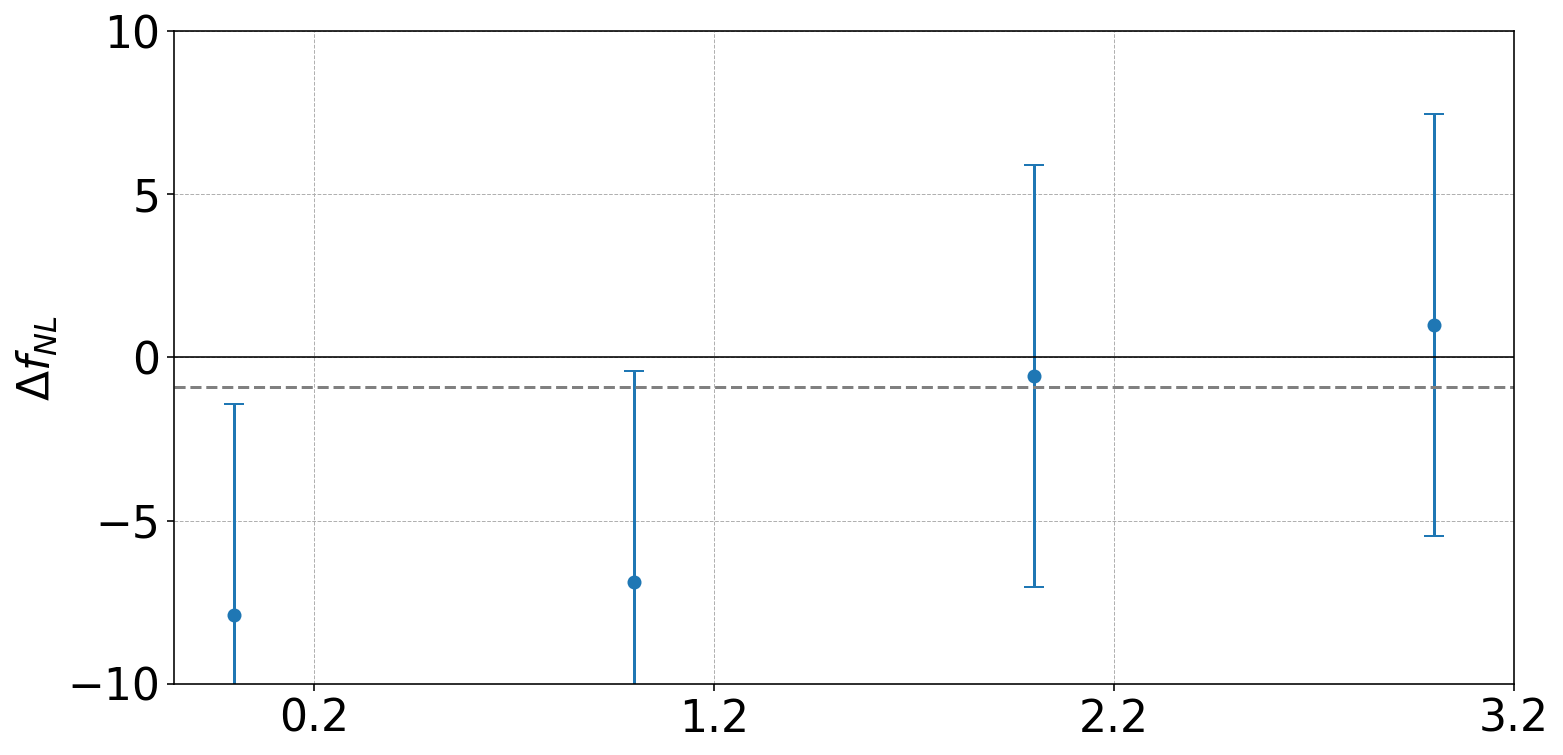

In [35]:

# Parameters
terms = [F_GR2,F_Full,F_WS,F_WSGR]#F_WA2[shape],F_RR2[shape],F_WAGR[shape],F_RRGR[shape]

x = np.arange(len(terms))  # Label positions
width = 0.2  # Bar width

fig, ax = plt.subplots(figsize=(12,6))
for i, shape in enumerate(['Loc']):#
    biases = [term[shape] for term in terms]
    
    ax.errorbar(x + i * width, biases, yerr=1/np.sqrt(F_[shape]), fmt='o', capsize=5)

# Customization
ax.axhline(-0.9,linestyle='--',color='grey')
ax.set_xticks(x + width)  # Center tick labels

ax.axhline(0, color='black', linewidth=0.8)  # Baseline for negatives
ax.set_ylabel('$\Delta f_{NL}$')
plt.grid(ls='--',lw=0.5)
#ax.legend()
plt.ylim(-10,10)
plt.show()

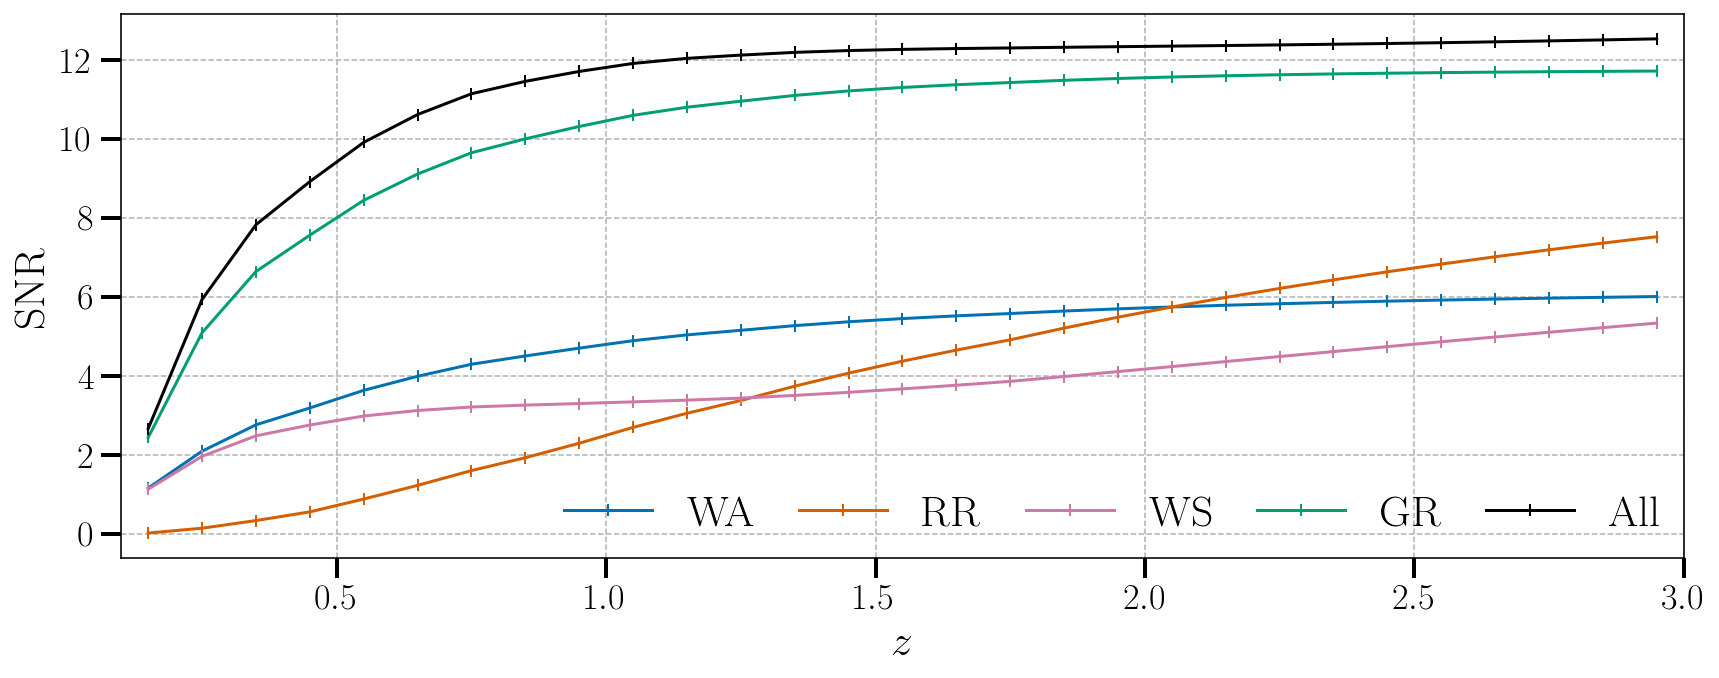

In [14]:
plt.figure(figsize=(14,5))   
if True:
    lstyles = ['-','--','-.'] #styles for different surveys
    for i,survey in enumerate(['CVlim']):# 'SKAO2','EUCLID','BGS'
        plt.plot(z_mid[survey],np.sqrt(np.cumsum(snr_WA1[survey].real)),lstyles[i],marker='|',label='WA',color=colors[0])
        plt.plot(z_mid[survey],np.sqrt(np.cumsum(snr_RR1[survey].real)),lstyles[i],marker='|',label='RR',color=colors[2])
        plt.plot(z_mid[survey],np.sqrt(np.cumsum(snr_WS1[survey].real)),lstyles[i],marker='|',label='WS',color=colors[3])
        plt.plot(z_mid[survey],np.sqrt(np.cumsum(snr_GR1[survey].real)),lstyles[i],marker='|',label='GR',color=colors[1])
        plt.plot(z_mid[survey],np.sqrt(np.cumsum(snr_dip[survey].real)),lstyles[i],marker='|',label='All',color='black')
        
plt.xlabel('$z$')
plt.grid(ls='--',lw=0.75)
plt.legend(ncol=5,frameon=False,title_fontsize=16,handlelength=2, columnspacing=1, handleheight=1, borderpad=0)

plt.xlim(0.1,3)
#plt.yscale('log')
plt.ylabel('SNR')
#plt.yscale('log')
#plt.ylim(0,20)
plt.savefig('plots/SNR_CVlim.png', bbox_inches='tight', dpi=400)

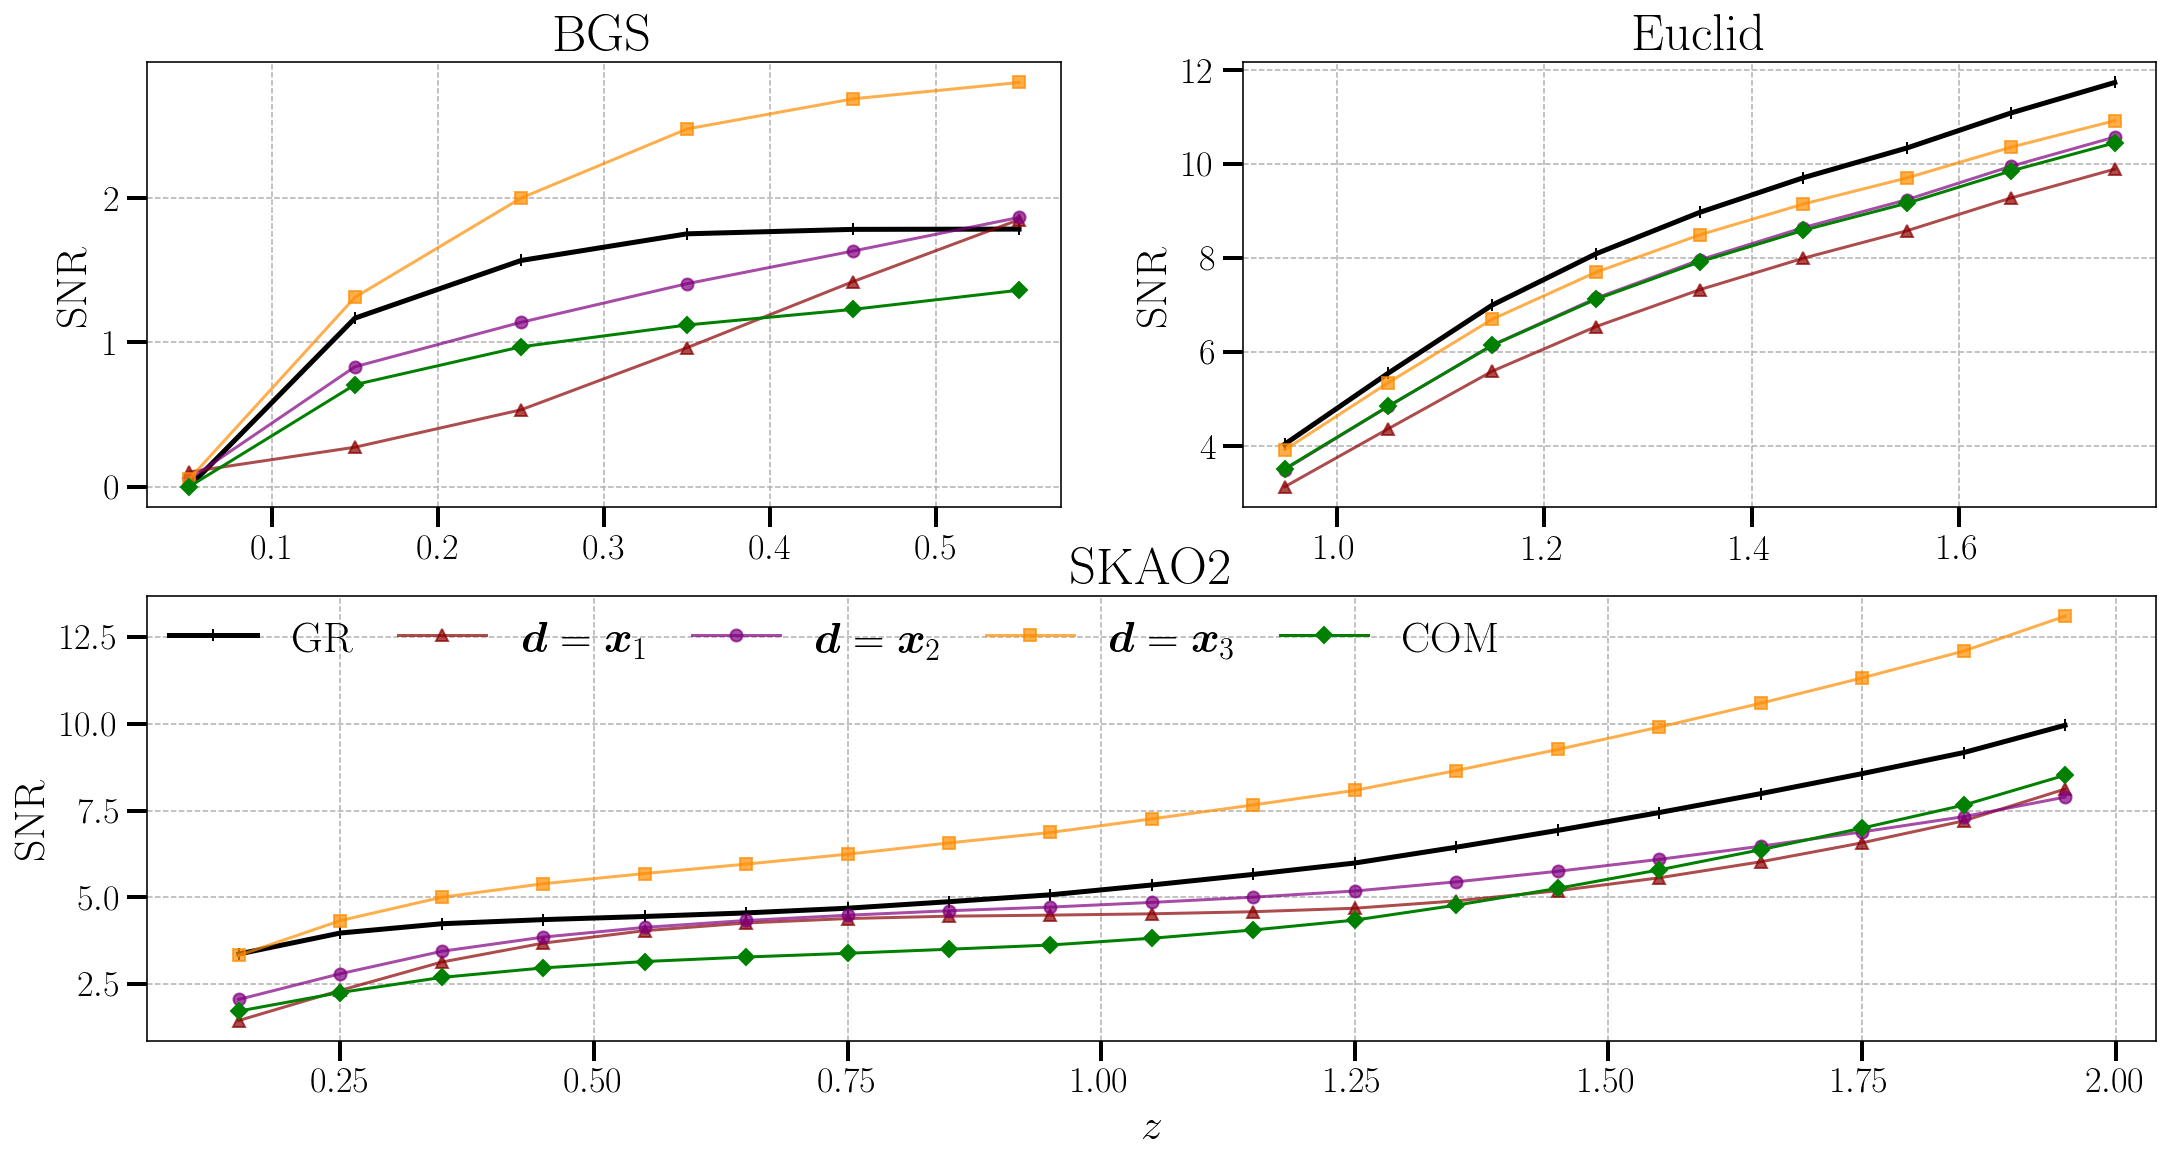

In [12]:
# Create figure
fig = plt.figure(figsize=(18,9))

axs = [[],[],[]]
# Create subplot 1 in the top left corner
axs[0] = plt.subplot2grid((2, 2), (0, 0))
axs[1] = plt.subplot2grid((2, 2), (0, 1))
axs[2] = plt.subplot2grid((2, 2), (1, 0), colspan=2)
for i,survey in enumerate(['BGS','Euclid','SKAO2']): 
    axs[i].plot(z_mid[survey],np.sqrt(np.cumsum(snr_GR1[survey].real)),'-',marker='|',linewidth=2.5,label='GR',color='black')
    axs[i].plot(z_mid[survey],np.sqrt(np.cumsum(snr_dip_x1[survey].real)),'-',marker='^',label=r'$\boldsymbol{d}=\boldsymbol{x}_1$',color='darkred',alpha=0.7)
    axs[i].plot(z_mid[survey],np.sqrt(np.cumsum(snr_dip_x2[survey].real)),'-',marker='o',label=r'$\boldsymbol{d}=\boldsymbol{x}_2$',color='purple',alpha=0.7)
    axs[i].plot(z_mid[survey],np.sqrt(np.cumsum(snr_dip[survey].real)),'-',marker='s',label=r'$\boldsymbol{d}=\boldsymbol{x}_3$',color='darkorange',alpha=0.7)
    axs[i].plot(z_mid[survey],np.sqrt(np.cumsum(snr_dip_COM[survey].real)),'-',marker='D',label='COM',color='green',alpha=1)
    axs[i].grid(ls='--',lw=0.75)
    axs[i].set_title(survey)
    axs[i].set_ylabel('SNR')
    
axs[0].set_title('BGS')
axs[1].set_title('Euclid')
axs[2].set_title('SKAO2')

axs[2].legend(ncol=5,frameon=False,title_fontsize=16,handlelength=2, columnspacing=1, handleheight=1, borderpad=0)
axs[2].set_xlabel('$z$')


plt.savefig('plots/SNR_dipole.png', bbox_inches='tight', dpi=400)

## Fisher


$$F_{ij} =\sum_k \frac{\partial B}{\partial \theta_i}C^{-1}\frac{\partial B}{\partial \theta_j}$$

In [15]:
fish_dict = {}

In [18]:
def get_fish(cosmo_funcs,func_list,l,m,r=0,s=0,sigma=None):
    """
    Add fisher matrix to dict for given l and survey
    """
    
    func_list = [WA1,RR1,GR1]
    func_list0 = [ WA_RR_GR_wa, WA_RR_GR_rr, WA_RR_GR_gr]

    N = len(func_list)#get size of matrix
    fish_mat = np.zeros((N,N))
    print("computing covariance martrix for {} ...".format(survey))
    for i in tqdm(range(N)):
        for j in range(N):
            if l == 0:
                fish_mat[i,j] =  fisherij(func_list0[i],func_list0[j],l,m,survey=survey)
            else:    
                fish_mat[i,j] =  fisherij(func_list[i],func_list[j],l,m,survey=survey)
                
    return fish_mat
    
    
#fish_mat_El1 = get_fish(1,0,survey='Euclid')
fish_mat_SKAl1 = get_fish(1,0,survey='SKAO2')
#fish_mat_Dl1 = get_fish(1,0,survey='BGS')

computing covariance martrix for SKAO2 ...


  0%|          | 0/3 [00:00<?, ?it/s]

In [17]:
class WA_RR_GR_wa:
    def l0(params,derivs,betas,r,s):
        return WA2.l0(params,r,s) +WAGR.l0(params,betas,r,s)+WARR.l0(params,derivs,r,s)
    
class WA_RR_GR_rr:
    def l0(params,derivs,betas,r,s):
        return RR2.l0(params,derivs,r,s)+WARR.l0(params,derivs,r,s)+RRGR.l0(params,derivs,betas,r,s)
    
class WA_RR_GR_gr:
    def l0(params,derivs,betas,r,s):
        return GR2.l0(params,betas)+WAGR.l0(params,betas,r,s)+RRGR.l0(params,derivs,betas,r,s)

[[1.79348543 1.73624056 0.1186029 ]
 [1.73624056 2.18061008 0.19656577]
 [0.1186029  0.19656577 0.02847274]]
[[ 0.03367773  0.00930819 -0.00775229]
 [ 0.00930819  0.15634317 -0.00544401]
 [-0.00775229 -0.00544401  0.01297192]]


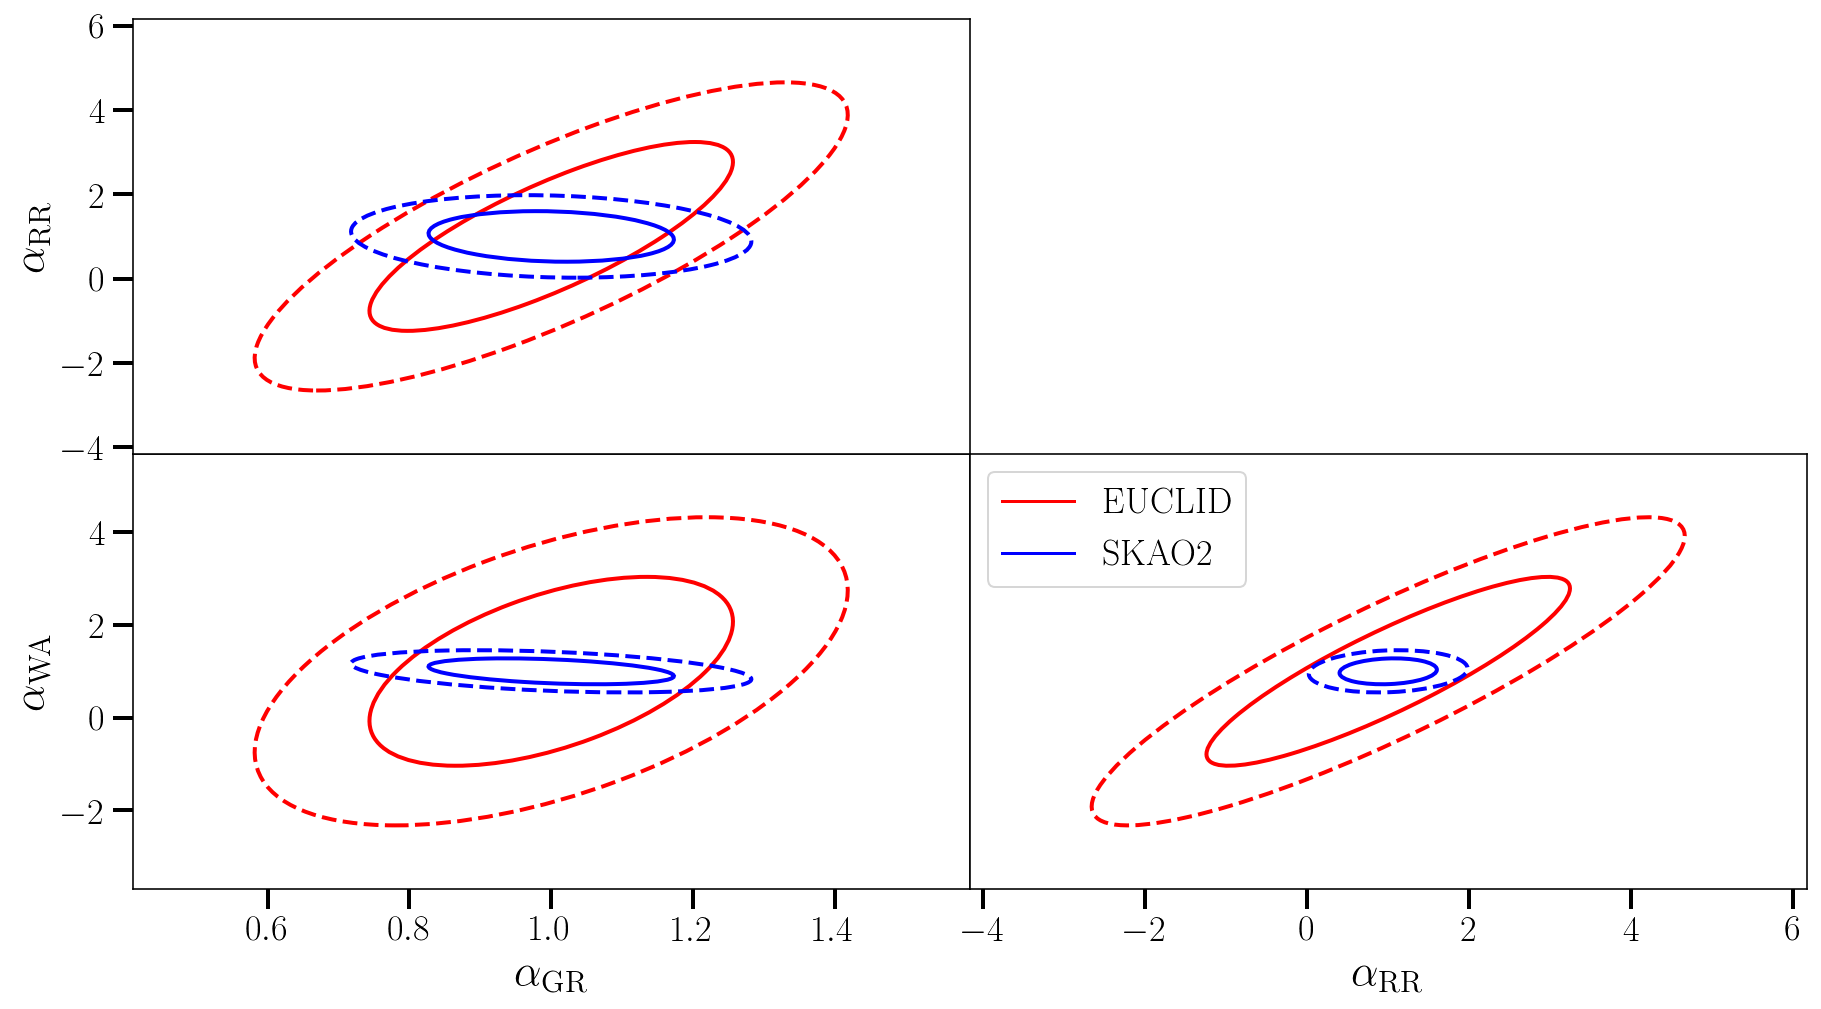

In [700]:
from Library.normal_corner_ellipse import *


cov_mat = np.linalg.inv(fish_mat_El1)
cov_mat2 = np.linalg.inv(fish_mat_SKAl1)
print(cov_mat)
print(cov_mat2)


# Variable labels for plotting, as a list of strings
varlabels = ['$\\alpha_{\\rm WA}$','$\\alpha_{\\rm RR}$','$\\alpha_{\\rm GR}$']

# Mean matrix, as a numpy array
mean = np.array([1, 1, 1])

# Make a corner plot
fig1,axs = normal_corner(cov_mat,mean,varlabels,covm2=cov_mat2,mean2=mean,figsize=(15,8),scale_factor=3.5)
axs[0].plot([], [],'-',color='red', label='EUCLID')
axs[0].plot([], [],'-',color='blue', label='SKAO2')
axs[0].legend(loc='upper left',fontsize=18,markerscale=0.8)

plt.savefig('plots/fisher.png', bbox_inches='tight', dpi=400)
plt.show()
